# BNLearn Results (Causenet-style Plots by Dataset)

In [16]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import sys
import numpy as np
import pandas as pd
from IPython.display import display

pd.set_option('display.max_rows', 2000)

REPO_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(REPO_ROOT))
sys.path.insert(0, str(REPO_ROOT / 'utils'))

from plotting import *

save_figs = False
debug = False

RESULTS_DIR = REPO_ROOT / 'results'

# Two running versions (FGS/NT and Random/MPC)
VERSIONS = ['bnlearn_big_fgs_nt', 'bnlearn_big_rnd_mpc']
# CSV with ABAPC and ABAPC-LLM single-run results to aggregate
CSV_ABAPC = RESULTS_DIR / 'merged_bnlearn.csv'
CSV_BFS = RESULTS_DIR / 'causal-bfs-bnlearn-results 1.csv'

# Display labels and styles (aligned with causenet notebook)
names_dict = {
    'random': 'Random',
    'pc': 'PC',
    'pc_max': 'Max-PC',
    'fgs': 'FGS',
    'spc': 'Shapley-PC',
    'mpc': 'MPC',
    'cpc': 'CPC',
    'abapc': 'ABAPC',
    'abapc_llm': 'ABAPC-LLM',
    'cam': 'CAM',
    'nt': 'NOTEARS-MLP',
    'mcsl': 'MCSL-MLP',
    'ges': 'GES',
    'aspcr': 'ASPCR',
    'llm_bfs': 'LLM-BFS',
}

symbols_dict = {
    'random': 'x',
    'pc': 'circle',
    'pc_max': 'circle-open',
    'fgs': 'triangle-up-dot',
    'spc': 'hexagon2-dot',
    'mpc': 'diamond-dot',
    'cpc': 'square-dot',
    'abapc': 'triangle-down-dot',
    'abapc_llm': 'triangle-down-open',
    'cam': 'star',
    'nt': 'pentagon-dot',
    'mcsl': 'cross-thin',
    'ges': 'circle-cross',
    'aspcr': 'diamond-open',
    'llm_bfs': 'star-diamond-dot',
}

colors_dict = {
    'random': '#7f7f7f',
    'pc': main_blue,
    'pc_max': sec_blue,
    'fgs': sec_orange,
    'spc': sec_green,
    'mpc': main_green,
    'cpc': '#c678dd',
    'abapc': '#bcbd22',
    'abapc_llm': sec_purple,
    'cam': main_orange,
    'nt': sec_blue,
    'mcsl': '#bcbd22',
    'ges': '#17becf',
    'aspcr': sec_purple,
    'llm_bfs': "#e377c2", 
}


# For labeling datasets (|V|, |E|). Use constants as in original bnlearn notebook.
dags_nodes_map = {'asia':8, 'cancer':5, 'earthquake':5, 'sachs':11, 'survey':6, 'alarm':37, 'child':20, 'insurance':27, 'hailfinder':56, 'hepar2':70}
dags_arcs_map = {'asia':8, 'cancer':4, 'earthquake':4, 'sachs':17, 'survey':6, 'alarm':46, 'child':25, 'insurance':52, 'hailfinder':66, 'hepar2':123}

default_methods = ['Random', 'FGS', 'NOTEARS-MLP', 'MPC', 'ABAPC', 'LLM-BFS', 'ABAPC-LLM']
inverse_names = {v: k for k, v in names_dict.items()}


In [17]:
# Load npy aggregated results for provided versions (cpdag and dag)
def load_npy(version: str, kind: str):
    path = RESULTS_DIR / f'stored_results_{version}{'_cpdag' if kind=='cpdag' else ''}.npy'
    if kind == 'cpdag':
        cols = ['dataset', 'model', 'elapsed_mean', 'elapsed_std', 'nnz_mean', 'nnz_std',
                'fdr_mean', 'fdr_std', 'tpr_mean', 'tpr_std', 'fpr_mean', 'fpr_std',
                'precision_mean', 'precision_std', 'recall_mean', 'recall_std',
                'F1_mean', 'F1_std', 'shd_mean', 'shd_std', 'SID_low_mean', 'SID_low_std', 'SID_high_mean', 'SID_high_std']
    else:
        cols = ['dataset', 'model', 'elapsed_mean', 'elapsed_std', 'nnz_mean', 'nnz_std',
                'fdr_mean', 'fdr_std', 'tpr_mean', 'tpr_std', 'fpr_mean', 'fpr_std',
                'precision_mean', 'precision_std', 'recall_mean', 'recall_std',
                'F1_mean', 'F1_std', 'shd_mean', 'shd_std', 'SID_mean', 'SID_std']
    if not path.exists():
        return pd.DataFrame(columns=cols)
    arr = np.load(path, allow_pickle=True)
    df = pd.DataFrame(arr, columns=cols)
    df['dataset'] = df['dataset'].astype(str)
    df['model'] = df['model'].astype(str)
    return df

cpdag_npy = pd.concat([load_npy(v, 'cpdag') for v in VERSIONS], ignore_index=True)
dag_npy = pd.concat([load_npy(v, 'dag') for v in VERSIONS], ignore_index=True)

display({'cpdag_npy': cpdag_npy.head(), 'dag_npy': dag_npy.head()})


{'cpdag_npy':       dataset        model elapsed_mean elapsed_std nnz_mean nnz_std fdr_mean  \
 0      cancer          FGS         0.11        0.14     3.68    0.47      0.0   
 1      cancer  NOTEARS-MLP         0.41        0.76     0.08    0.27      0.0   
 2  earthquake          FGS         0.09        0.01     4.62    0.64     0.12   
 3  earthquake  NOTEARS-MLP         2.01        0.81      4.0    0.45     0.02   
 4      survey          FGS         0.09        0.01      3.3    0.84      0.6   
 
   fdr_std tpr_mean tpr_std  ... recall_mean recall_std F1_mean F1_std  \
 0     0.0     0.92    0.12  ...        0.42       0.12    0.43    0.1   
 1     0.0     0.02    0.07  ...        0.02       0.07     0.4    0.0   
 2    0.12      1.0     0.0  ...         0.5        0.0    0.47   0.03   
 3    0.08     0.97    0.08  ...        0.56       0.17    0.56   0.17   
 4    0.16     0.21    0.08  ...        0.21       0.08    0.27    0.1   
 
   shd_mean shd_std SID_low_mean SID_low_std SI

In [24]:
# Aggregate ABAPC and ABAPC-LLM from merged_bnlearn.csv
impl_map = {'org': 'ABAPC', 'new': 'ABAPC-LLM'}

def aggregate_from_csv(csv_path: Path):
    if not csv_path.exists():
        return pd.DataFrame(), pd.DataFrame()
    df = pd.read_csv(csv_path)
    df['model'] = df['impl'].map(impl_map)
    df = df[~df['model'].isna()].copy()
    # Meta
    meta = df.groupby(['dataset', 'model']).agg(num_nodes=('num_nodes','first'), num_edges=('num_edges','first')).reset_index()

    # DAG metrics
    dag_cols = ['dag_nnz','dag_fdr','dag_tpr','dag_fpr','dag_precision','dag_recall','dag_F1','dag_shd','dag_sid']
    dag_agg = df.groupby(['dataset','model'])[dag_cols + ['time']].agg(['mean','std']).reset_index()
    dag_agg.columns = ['dataset','model'] + ['_'.join(col).strip('_').replace('time_', 'elapsed_') for col in dag_agg.columns[2:]]
    # Rename dag_* to base names to match plotting expectations
    rename_map = {
        'dag_nnz_mean':'nnz_mean','dag_nnz_std':'nnz_std',
        'dag_fdr_mean':'fdr_mean','dag_fdr_std':'fdr_std',
        'dag_tpr_mean':'tpr_mean','dag_tpr_std':'tpr_std',
        'dag_fpr_mean':'fpr_mean','dag_fpr_std':'fpr_std',
        'dag_precision_mean':'precision_mean','dag_precision_std':'precision_std',
        'dag_recall_mean':'recall_mean','dag_recall_std':'recall_std',
        'dag_F1_mean':'F1_mean','dag_F1_std':'F1_std',
        'dag_shd_mean':'shd_mean','dag_shd_std':'shd_std',
        'dag_sid_mean':'SID_mean','dag_sid_std':'SID_std',
    }
    dag_agg = dag_agg.rename(columns=rename_map)
    dag_agg = dag_agg.merge(meta, on=['dataset','model'], how='left')

    # CPDAG metrics
    cp_cols = ['cpdag_nnz','cpdag_fdr','cpdag_tpr','cpdag_fpr','cpdag_precision','cpdag_recall','cpdag_F1','cpdag_shd','cpdag_sid_low','cpdag_sid_high']
    cp_agg = df.groupby(['dataset','model'])[cp_cols + ['time']].agg(['mean','std']).reset_index()
    cp_agg.columns = ['dataset','model'] + ['_'.join(col).strip('_').replace('time_', 'elapsed_') for col in cp_agg.columns[2:]]
    cp_rename = {
        'cpdag_nnz_mean':'nnz_mean','cpdag_nnz_std':'nnz_std',
        'cpdag_fdr_mean':'fdr_mean','cpdag_fdr_std':'fdr_std',
        'cpdag_tpr_mean':'tpr_mean','cpdag_tpr_std':'tpr_std',
        'cpdag_fpr_mean':'fpr_mean','cpdag_fpr_std':'fpr_std',
        'cpdag_precision_mean':'precision_mean','cpdag_precision_std':'precision_std',
        'cpdag_recall_mean':'recall_mean','cpdag_recall_std':'recall_std',
        'cpdag_F1_mean':'F1_mean','cpdag_F1_std':'F1_std',
        'cpdag_shd_mean':'shd_mean','cpdag_shd_std':'shd_std',
        'cpdag_sid_low_mean':'SID_low_mean','cpdag_sid_low_std':'SID_low_std',
        'cpdag_sid_high_mean':'SID_high_mean','cpdag_sid_high_std':'SID_high_std',
    }
    cp_agg = cp_agg.rename(columns=cp_rename)
    cp_agg = cp_agg.merge(meta, on=['dataset','model'], how='left')

    return dag_agg, cp_agg

dag_csv, cpdag_csv = aggregate_from_csv(CSV_ABAPC)
display({'dag_csv': dag_csv.head(), 'cpdag_csv': cpdag_csv.head()})

# Aggregate LLM-BFS CSV (single-run style)
def aggregate_bfs_csv(csv_path: Path):
    if not csv_path.exists():
        return pd.DataFrame(), pd.DataFrame()
    df = pd.read_csv(csv_path)
    df['dataset'] = df['dataset'].astype(str)
    df['model'] = 'LLM-BFS'
    # Add meta from known maps
    df['num_nodes'] = df['dataset'].str.lower().map(dags_nodes_map)
    df['num_edges'] = df['dataset'].str.lower().map(dags_arcs_map)
    # DAG agg
    dag_cols = ['dag_nnz','dag_fdr','dag_tpr','dag_fpr','dag_precision','dag_recall','dag_F1','dag_shd','dag_sid']
    dag_agg = df.groupby(['dataset','model'])[dag_cols + ['time']].agg(['mean','std']).reset_index()
    dag_agg.columns = ['dataset','model'] + ['_'.join(col).strip('_').replace('time_', 'elapsed_') for col in dag_agg.columns[2:]]
    rename_map = {
        'dag_nnz_mean':'nnz_mean','dag_nnz_std':'nnz_std',
        'dag_fdr_mean':'fdr_mean','dag_fdr_std':'fdr_std',
        'dag_tpr_mean':'tpr_mean','dag_tpr_std':'tpr_std',
        'dag_fpr_mean':'fpr_mean','dag_fpr_std':'fpr_std',
        'dag_precision_mean':'precision_mean','dag_precision_std':'precision_std',
        'dag_recall_mean':'recall_mean','dag_recall_std':'recall_std',
        'dag_F1_mean':'F1_mean','dag_F1_std':'F1_std',
        'dag_shd_mean':'shd_mean','dag_shd_std':'shd_std',
        'dag_sid_mean':'SID_mean','dag_sid_std':'SID_std',
    }
    dag_agg = dag_agg.rename(columns=rename_map)
    # Merge meta
    meta = df.groupby(['dataset','model']).agg(num_nodes=('num_nodes','first'), num_edges=('num_edges','first')).reset_index()
    dag_agg = dag_agg.merge(meta, on=['dataset','model'], how='left')
    # CPDAG agg
    cp_cols = ['cpdag_nnz','cpdag_fdr','cpdag_tpr','cpdag_fpr','cpdag_precision','cpdag_recall','cpdag_F1','cpdag_shd','cpdag_sid_low','cpdag_sid_high']
    cp_agg = df.groupby(['dataset','model'])[cp_cols + ['time']].agg(['mean','std']).reset_index()
    cp_agg.columns = ['dataset','model'] + ['_'.join(col).strip('_').replace('time_', 'elapsed_') for col in cp_agg.columns[2:]]
    cp_rename = {
        'cpdag_nnz_mean':'nnz_mean','cpdag_nnz_std':'nnz_std',
        'cpdag_fdr_mean':'fdr_mean','cpdag_fdr_std':'fdr_std',
        'cpdag_tpr_mean':'tpr_mean','cpdag_tpr_std':'tpr_std',
        'cpdag_fpr_mean':'fpr_mean','cpdag_fpr_std':'fpr_std',
        'cpdag_precision_mean':'precision_mean','cpdag_precision_std':'precision_std',
        'cpdag_recall_mean':'recall_mean','cpdag_recall_std':'recall_std',
        'cpdag_F1_mean':'F1_mean','cpdag_F1_std':'F1_std',
        'cpdag_shd_mean':'shd_mean','cpdag_shd_std':'shd_std',
        'cpdag_sid_low_mean':'SID_low_mean','cpdag_sid_low_std':'SID_low_std',
        'cpdag_sid_high_mean':'SID_high_mean','cpdag_sid_high_std':'SID_high_std',
    }
    cp_agg = cp_agg.rename(columns=cp_rename)
    cp_agg = cp_agg.merge(meta, on=['dataset','model'], how='left')
    return dag_agg, cp_agg

bfs_dag_csv, bfs_cpdag_csv = aggregate_bfs_csv(CSV_BFS)
display({'bfs_dag_csv': bfs_dag_csv.head(), 'bfs_cpdag_csv': bfs_cpdag_csv.head()})


{'dag_csv':       dataset      model  nnz_mean   nnz_std  fdr_mean   fdr_std  tpr_mean  \
 0        asia      ABAPC  4.396667  0.912803  0.323887  0.197561   0.37000   
 1        asia  ABAPC-LLM  4.490000  0.634791  0.008000  0.039590   0.55625   
 2      cancer      ABAPC  3.360000  0.631163  0.443663  0.271930   0.47850   
 3      cancer  ABAPC-LLM  3.360000  0.631163  0.004000  0.028284   0.83500   
 4  earthquake      ABAPC  4.040000  0.197949  0.018000  0.080026   0.99000   
 
     tpr_std  fpr_mean   fpr_std  ...   F1_mean    F1_std  shd_mean   shd_std  \
 0  0.128119  0.071833  0.049427  ...  0.473380  0.151373     5.060  1.063068   
 1  0.079107  0.002000  0.009897  ...  0.709482  0.066670     3.590  0.690238   
 2  0.276134  0.241004  0.158290  ...  0.603586  0.179352     2.106  1.148097   
 3  0.148204  0.003334  0.023575  ...  0.900614  0.090698     0.680  0.586933   
 4  0.070711  0.013334  0.056744  ...  0.985556  0.073437     0.100  0.462910   
 
     SID_mean   SID_std  

{'bfs_dag_csv':       dataset    model  nnz_mean  nnz_std  fdr_mean  fdr_std  tpr_mean  \
 0        asia  LLM-BFS      13.0      NaN    0.3846      NaN    1.0000   
 1      cancer  LLM-BFS       8.0      NaN    0.5000      NaN    1.0000   
 2       child  LLM-BFS      62.0      NaN    0.7581      NaN    0.6000   
 3  earthquake  LLM-BFS       8.0      NaN    0.5000      NaN    1.0000   
 4       sachs  LLM-BFS      16.0      NaN    0.6875      NaN    0.2941   
 
    tpr_std  fpr_mean  fpr_std  ...  F1_mean  F1_std  shd_mean  shd_std  \
 0      NaN    0.2500      NaN  ...   0.7619     NaN       5.0      NaN   
 1      NaN    0.6667      NaN  ...   0.6667     NaN       4.0      NaN   
 2      NaN    0.2848      NaN  ...   0.3448     NaN      56.0      NaN   
 3      NaN    0.6667      NaN  ...   0.6667     NaN       4.0      NaN   
 4      NaN    0.2895      NaN  ...   0.3030     NaN      20.0      NaN   
 
    SID_mean  SID_std  elapsed_mean  elapsed_std  num_nodes  num_edges  
 0      

In [27]:
datasets_to_plot = {'cancer','earthquake','asia', 'sachs', 'survey', 'alarm', 'child', 'insurance', 'hailfinder', 'hepar2'}
# Merge npy and csv aggregates per kind
cpdag_all = pd.concat([cpdag_npy, cpdag_csv, bfs_cpdag_csv], ignore_index=True, sort=False)
dag_all = pd.concat([dag_npy, dag_csv, bfs_dag_csv], ignore_index=True, sort=False)

## filter to datasets of interest
cpdag_all = cpdag_all[cpdag_all['dataset'].str.lower().isin(datasets_to_plot)].copy()
dag_all = dag_all[dag_all['dataset'].str.lower().isin(datasets_to_plot)].copy()

# Add node/edge counts for label/normalisation
for df in (cpdag_all, dag_all):
    if 'num_edges' not in df: df['num_edges'] = np.nan
    if 'num_nodes' not in df: df['num_nodes'] = np.nan
    # Fill from known maps where missing
    base_names = df['dataset'].astype(str).str.replace('<br>.*','', regex=True).str.lower()
    df['n_edges'] = base_names.map(dags_arcs_map).fillna(df['num_edges']).astype(float)
    df['n_nodes'] = base_names.map(dags_nodes_map).fillna(df['num_nodes']).astype(float)
    # Nice dataset label
    ds_upper = base_names.str.upper()
    df['dataset'] = ds_upper + '<br> |V|=' + df['n_nodes'].fillna(0).astype(int).astype(str) + ', |E|=' + df['n_edges'].fillna(0).astype(int).astype(str)

# Compute normalised metrics
def add_normals(df, sid_cols):
    if 'shd_mean' in df and 'n_edges' in df:
        df['p_shd_mean'] = df['shd_mean'].astype(float) / df['n_edges'].astype(float)
        df['p_shd_std'] = df['shd_std'].astype(float) / df['n_edges'].astype(float)
    for c in sid_cols:
        mean_c, std_c = f'{c}_mean', f'{c}_std'
        if mean_c in df and 'n_edges' in df:
            df[f'p_{c}_mean'] = df[mean_c].astype(float) / df['n_edges'].astype(float)
            df[f'p_{c}_std'] = df[std_c].astype(float) / df['n_edges'].astype(float)
    return df

cpdag_all = add_normals(cpdag_all, sid_cols=['SID_low','SID_high'])
dag_all = add_normals(dag_all, sid_cols=['SID'])

available_models_cpdag = sorted(cpdag_all['model'].unique()) if len(cpdag_all)>0 else []
available_models_dag = sorted(dag_all['model'].unique()) if len(dag_all)>0 else []
print('CPDAG models:', available_models_cpdag)
print('DAG models:', available_models_dag)


CPDAG models: ['ABAPC', 'ABAPC-LLM', 'FGS', 'LLM-BFS', 'MPC', 'NOTEARS-MLP', 'Random']
DAG models: ['ABAPC', 'ABAPC-LLM', 'FGS', 'LLM-BFS', 'MPC', 'NOTEARS-MLP', 'Random']


In [28]:
# Plots by dataset (CPDAG)
if len(cpdag_all):
    methods = [m for m in default_methods if m in cpdag_all['model'].unique()]
    if 'p_SID_low_mean' in cpdag_all:
        cpdag_all['p_SID_low_mean'] = cpdag_all['p_SID_low_mean'].replace(0, 0.03)
    if 'p_SID_high_mean' in cpdag_all:
        cpdag_all['p_SID_high_mean'] = cpdag_all['p_SID_high_mean'].replace(0, 0.03)
    double_bar_chart_plotly(
        cpdag_all, ['p_SID_low','p_SID_high'], names_dict, colors_dict, methods,
        save_figs=save_figs, font_size=24, output_name=str(REPO_ROOT / 'results/figs/Fig.bn_cpdag_SID.html'),
        debug=False, range_y1=[0,6], range_y2=[0,6]
    )
    double_bar_chart_plotly(
        cpdag_all, ['p_shd','F1'], names_dict, colors_dict, methods,
        save_figs=save_figs, font_size=23, output_name=str(REPO_ROOT / 'results/figs/Fig.bn_cpdag_SHD_F1.html'),
        debug=False, range_y1=[0,2], range_y2=[0,1.1]
    )
    double_bar_chart_plotly(
        cpdag_all, ['precision','recall'], names_dict, colors_dict, methods,
        save_figs=save_figs, font_size=23, output_name=str(REPO_ROOT / 'results/figs/Fig.bn_cpdag_prec_rec.html'),
        debug=False
    )
    bar_chart_plotly(
        cpdag_all, 'nnz', names_dict, colors_dict, methods,
        save_figs=save_figs, font_size=23, output_name=str(REPO_ROOT / 'results/figs/Fig.bn_cpdag_nnz.html'),
        debug=False
    )
else:
    print('No CPDAG results found.')


In [21]:
# Plots by dataset (DAG)
if len(dag_all):
    methods = [m for m in default_methods if m in dag_all['model'].unique()]
    double_bar_chart_plotly(
        dag_all, ['p_shd','F1'], names_dict, colors_dict, methods,
        save_figs=save_figs, font_size=23, output_name=str(REPO_ROOT / 'results/figs/Fig.bn_dag_SHD_SID.html'),
        debug=False, range_y1=[0,2], range_y2=[0,5.6], rect_exp=0.015
    )
    bar_chart_plotly(
        dag_all, 'p_SID', names_dict, colors_dict, methods,
        save_figs=save_figs, font_size=23, output_name=str(REPO_ROOT / 'results/figs/Fig.bn_dag_F1.html'),
        debug=False
    )
    double_bar_chart_plotly(
        dag_all, ['precision','recall'], names_dict, colors_dict, methods,
        save_figs=save_figs, font_size=23, output_name=str(REPO_ROOT / 'results/figs/Fig.bn_dag_prec_rec.html'),
        debug=False
    )
    bar_chart_plotly(
        dag_all, 'nnz', names_dict, colors_dict, methods,
        save_figs=save_figs, font_size=23, output_name=str(REPO_ROOT / 'results/figs/Fig.bn_dag_nnz.html'),
        debug=False
    )
else:
    print('No DAG results found.')



=== Aggregated heatmap: dag_F1 ===


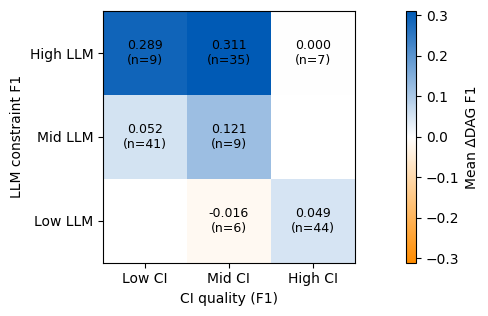

=== Per-dataset heatmaps: dag_F1 ===


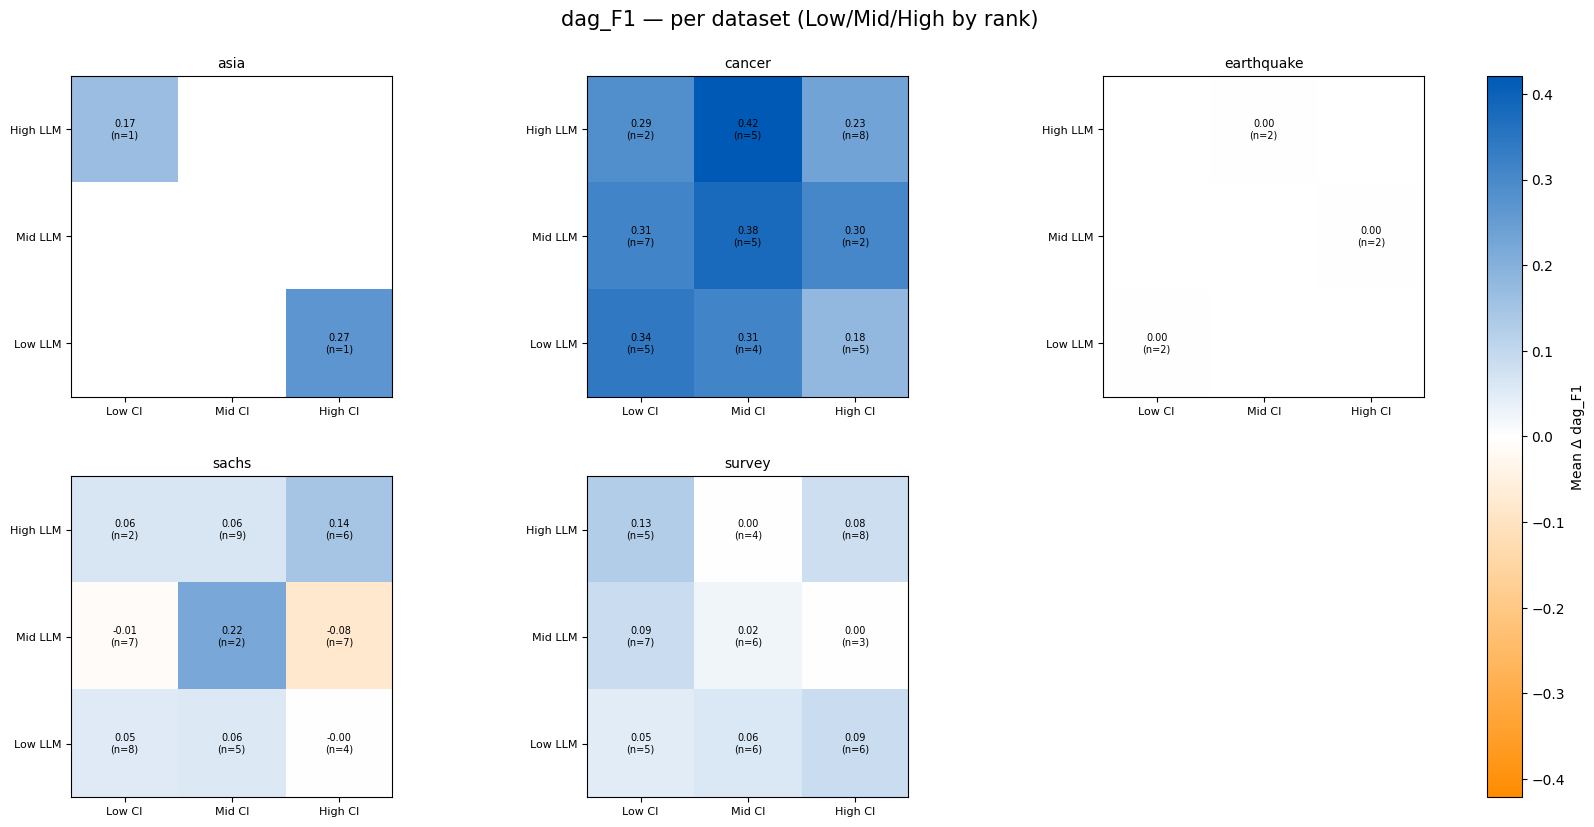


=== Aggregated heatmap: dag_shd ===


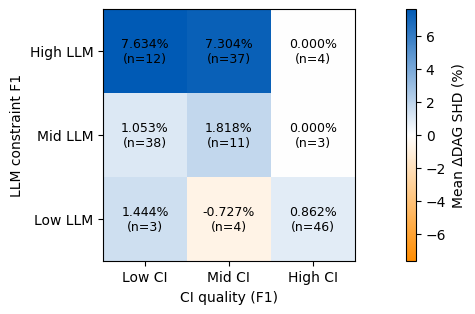

=== Per-dataset heatmaps: dag_shd ===


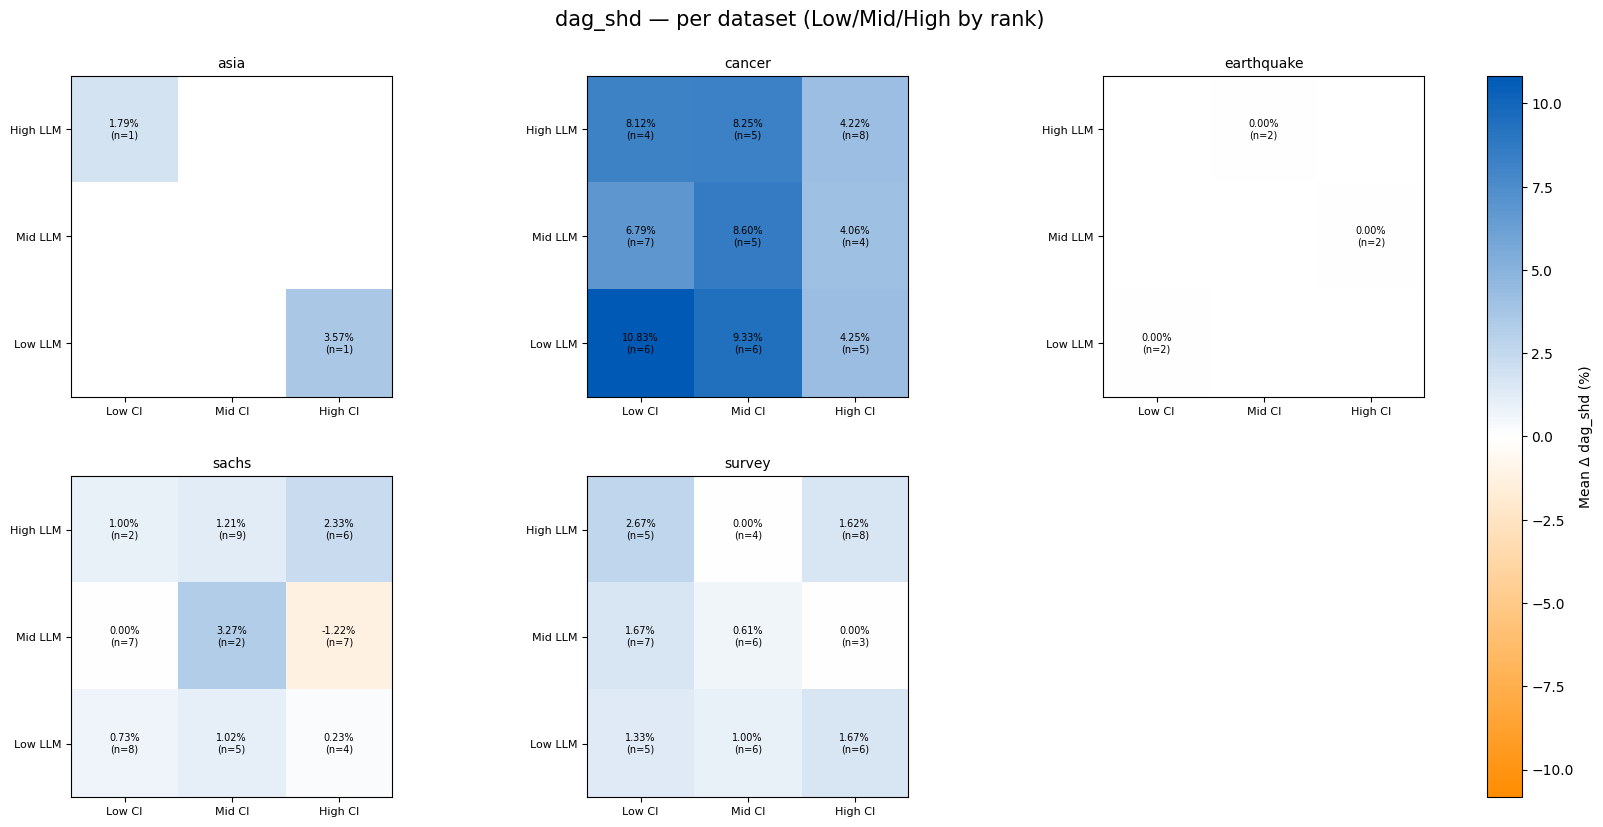


=== Aggregated heatmap: dag_sid ===


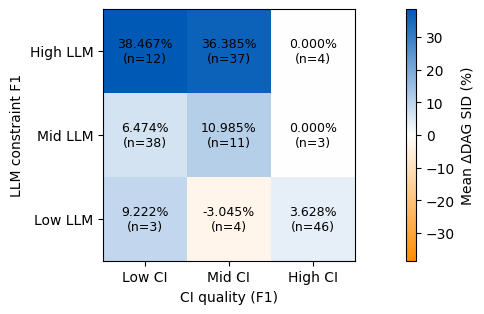

=== Per-dataset heatmaps: dag_sid ===


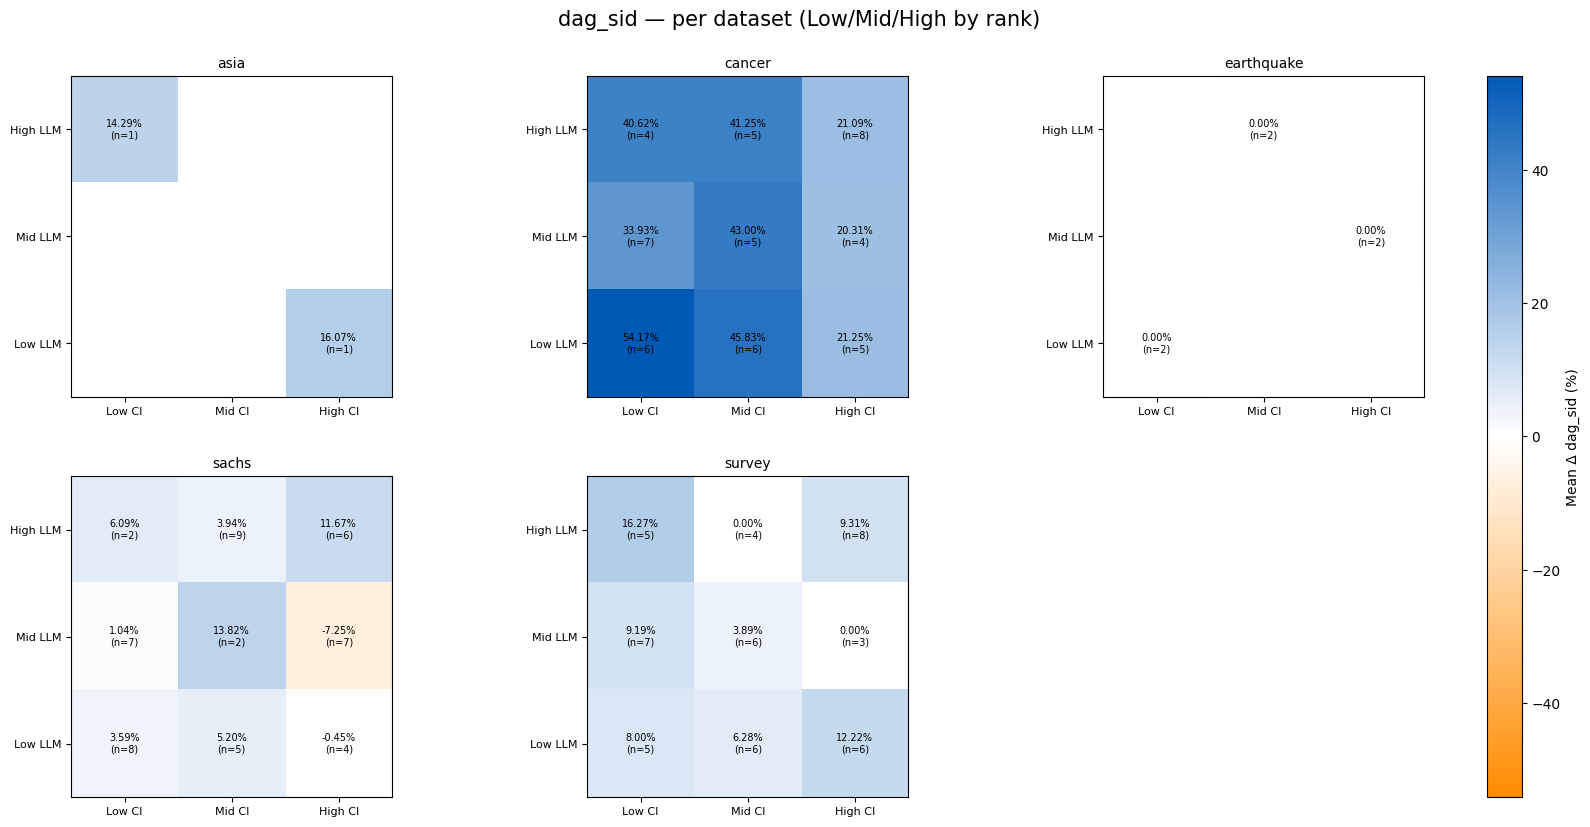

In [40]:
# Re-run the plotting cell (sometimes the environment resets).

import os, re, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

INPATH = "../results/merged_bnlearn 1.csv"
df_raw = pd.read_csv(INPATH)

# LLM quality detection
if "prior_forbidden_F1" in df_raw.columns and "prior_required_F1" in df_raw.columns:
    df_raw["prior_overall_F1"] = df_raw[["prior_forbidden_F1","prior_required_F1"]].mean(axis=1)
LLM_COL = None
for c in ["prior_overall_F1", "AP_F1", "prior_required_F1", "prior_forbidden_F1", "prior_forbidden_Precision", "AP"]:
    if c in df_raw.columns:
        LLM_COL = c; break

CI_COL = next((c for c in df_raw.columns if c.lower() in {"cit_f1","ci_f1","citf1"}), None)
if CI_COL is None:
    CI_COL = next((c for c in df_raw.columns if c.lower() in {"cit_precision","ci_precision","ciprecision"}), None)

present_metrics = [m for m in ["dag_F1","dag_shd","dag_sid","cpdag_F1","cpdag_shd","cpdag_sid_low","cpdag_sid_high"] if m in df_raw.columns]
keep_cols = ["dataset","seed","impl","num_nodes",CI_COL,LLM_COL] + present_metrics
df_raw = df_raw[keep_cols].copy()

# Aggregate
agg = (df_raw.groupby(["dataset","seed","impl"], as_index=False)
       .mean(numeric_only=True))
if "cpdag_sid_low" in agg.columns and "cpdag_sid_high" in agg.columns:
    agg["cpdag_sid_avg"] = agg[["cpdag_sid_low","cpdag_sid_high"]].mean(axis=1)

def build_runlevel_avg(df_in, metric_col, higher_is_better, graph_kind):
    if metric_col not in df_in.columns: return None, ""
    ci = (df_in[df_in["impl"]=="org"]
          [["dataset","seed","num_nodes",CI_COL,metric_col]]
          .rename(columns={"num_nodes":"n_nodes_ci",CI_COL:"ci_quality",metric_col:"ci"}))
    cb = (df_in[df_in["impl"]=="new"]
          [["dataset","seed","num_nodes",CI_COL,LLM_COL,metric_col]]
          .rename(columns={"num_nodes":"n_nodes_new",CI_COL:"ci_quality_new",LLM_COL:"llm_quality",metric_col:"comb"}))
    m = pd.merge(cb, ci, on=["dataset","seed"], how="inner")
    if m.empty: return None, ""
    m["n_nodes"] = m["n_nodes_new"].fillna(m["n_nodes_ci"])
    if higher_is_better:
        m["delta"] = m["comb"] - m["ci"]; units=""
    else:
        n = m["n_nodes"].astype(float)
        capacity = n*(n-1) if graph_kind=="dag" else n*(n-1)/2.0
        capacity = capacity.replace(0, np.nan)
        m["delta"] = 100.0*(m["ci"] - m["comb"])/capacity; units="%"
    m["ci_quality"] = pd.to_numeric(m["ci_quality"], errors="coerce").clip(0,1)
    m["llm_quality"] = pd.to_numeric(m["llm_quality"], errors="coerce").clip(0,1)
    return m, units

def make_cmap_blue_good_orange_bad():
    return LinearSegmentedColormap.from_list(
        "good_blue_bad_orange",
        [(255/255,140/255,0/255), (1,1,1), (0/255,90/255,181/255)],
        N=256
    )

def tie_safe_qcut_labels(series, labels):
    s = pd.to_numeric(series, errors="coerce")
    ranks = s.rank(method="first")
    norm = ranks / (ranks.max() if ranks.max() else 1)
    cats = pd.qcut(norm, q=len(labels), labels=labels)
    return cats

def compute_grid_q3_equalcount(m):
    ci_labels  = ["Low CI","Mid CI","High CI"]
    llm_labels = ["Low LLM","Mid LLM","High LLM"]
    m = m.dropna(subset=["ci_quality","llm_quality","delta"]).copy()
    m["ci_bin"]  = tie_safe_qcut_labels(m["ci_quality"],  ci_labels)
    m["llm_bin"] = tie_safe_qcut_labels(m["llm_quality"], llm_labels)
    row_order = list(m["llm_bin"].cat.categories)[::-1]
    col_order = list(m["ci_bin"].cat.categories)
    grid_mean = np.full((3,3), np.nan); grid_count = np.zeros((3,3), dtype=int)
    for i, rlab in enumerate(row_order):
        for j, clab in enumerate(col_order):
            vals = m.loc[(m["llm_bin"]==rlab) & (m["ci_bin"]==clab), "delta"].astype(float)
            if len(vals)>0:
                grid_mean[i,j] = float(vals.mean()); grid_count[i,j] = int(len(vals))
    return grid_mean, grid_count, row_order, col_order

def plot_overall_q3_equalcount(m, metric_label, units):
    grid_mean, grid_count, row_labels, col_labels = compute_grid_q3_equalcount(m)
    vmax = np.nanmax(np.abs(grid_mean)) if np.any(~np.isnan(grid_mean)) else 1.0
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    cmap = make_cmap_blue_good_orange_bad()
    fig = plt.figure(figsize=(4.8,3.4))
    ax = fig.add_axes([0.12,0.16,0.66,0.74])
    im = ax.imshow(grid_mean, cmap=cmap, norm=norm, aspect="equal")
    ax.set_xticks(range(len(col_labels))); ax.set_xticklabels(col_labels, fontsize=10)
    ax.set_yticks(range(len(row_labels))); ax.set_yticklabels(row_labels, fontsize=10)
    ax.set_xlabel("CI quality (F1)")
    ax.set_ylabel("LLM constraint F1")
    for i in range(len(row_labels)):
        for j in range(len(col_labels)):
            if not np.isnan(grid_mean[i,j]):
                ax.text(j,i,f"{grid_mean[i,j]:.3f}{units}\n(n={grid_count[i,j]})", ha="center", va="center", fontsize=9)
    cax = fig.add_axes([0.82,0.16,0.02,0.74]); cb = fig.colorbar(im, cax=cax)
    cb.set_label(f"Mean Δ{metric_label}{(' ('+units+')') if units else ''}")
    plt.show()

def plot_by_dataset_panels(m, metric_label, units):
    datasets = sorted(m["dataset"].unique())
    n = len(datasets)
    if n == 0:
        print("No datasets found."); return
    ncols = 3; nrows = math.ceil(n/ncols)
    fig = plt.figure(figsize=(5.0*ncols+2.2, 4.4*nrows))
    left, right, top, bottom = 0.05, 0.11, 0.08, 0.10
    wspace, hspace = 0.06, 0.09
    grid_w = 1 - left - right; grid_h = 1 - top - bottom
    cell_w = (grid_w - (ncols-1)*wspace)/ncols; cell_h = (grid_h - (nrows-1)*hspace)/nrows
    panels = []; vmax = 0.0
    for d in datasets:
        sub = m[m["dataset"]==d]
        gm, gc, yl, xl = compute_grid_q3_equalcount(sub)
        vmax = max(vmax, np.nanmax(np.abs(gm)) if np.any(~np.isnan(gm)) else 0.0)
        panels.append((d, gm, gc, yl, xl))
    if vmax == 0: vmax = 1.0
    cmap = make_cmap_blue_good_orange_bad()
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    for idx, (d, gm, gc, yl, xl) in enumerate(panels):
        r = idx // ncols; c = idx % ncols
        ax = fig.add_axes([left + c*(cell_w+wspace), 1 - top - (r+1)*cell_h - r*hspace, cell_w, cell_h])
        im = ax.imshow(gm, cmap=cmap, norm=norm, aspect="equal")
        ax.set_xticks(range(len(xl))); ax.set_xticklabels(xl, fontsize=8)
        ax.set_yticks(range(len(yl))); ax.set_yticklabels(yl, fontsize=8)
        ax.set_title(d, fontsize=10)
        for i in range(len(yl)):
            for j in range(len(xl)):
                if not np.isnan(gm[i,j]):
                    ax.text(j,i,f"{gm[i,j]:.2f}{units}\n(n={gc[i,j]})", ha="center", va="center", fontsize=7)
    cax = fig.add_axes([1 - right + 0.01, bottom, 0.02, grid_h])
    cb = fig.colorbar(im, cax=cax); cb.set_label(f"Mean Δ {metric_label}{(' ('+units+')') if units else ''}")
    fig.suptitle(f"{metric_label} — per dataset (Low/Mid/High by rank)", fontsize=15, y=0.995)
    plt.show()

# Build metric tables
run = {}; units = {}
def add_metric(metric, hib, kind):
    m, u = build_runlevel_avg(agg, metric, hib, kind)
    if m is not None:
        run[metric] = m; units[metric] = u

add_metric("dag_F1", True, "dag")
add_metric("dag_shd", False, "dag")
add_metric("dag_sid", False, "dag")
add_metric("cpdag_F1", True, "cpdag")
add_metric("cpdag_shd", False, "cpdag")
if "cpdag_sid_low" in agg.columns and "cpdag_sid_high" in agg.columns:
    agg["cpdag_sid_avg"] = agg[["cpdag_sid_low","cpdag_sid_high"]].mean(axis=1)
add_metric("cpdag_sid_avg", False, "cpdag")

metric_labels = {
    "dag_F1": "DAG F1",
    "dag_shd": "DAG SHD",
    "dag_sid": "DAG SID",
    "cpdag_F1": "CPDAG F1",
    "cpdag_shd": "CPDAG SHD",
    "cpdag_sid_avg": "CPDAG SID (avg)",
}

# Show aggregated and per-dataset panels for each available metric
for metric in ["dag_F1","dag_shd","dag_sid",#"cpdag_F1","cpdag_shd","cpdag_sid_avg"
               ]:
    if metric in run:
        print(f"\n=== Aggregated heatmap: {metric} ===")
        plot_overall_q3_equalcount(run[metric], metric_labels[metric], units[metric])
        print(f"=== Per-dataset heatmaps: {metric} ===")
        plot_by_dataset_panels(run[metric], metric, units[metric])
